Upload hyperspectral data (.npy)...


Saving indianpinearray.npy to indianpinearray (2).npy
Upload corresponding label data (.npy)...


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Saving IPgt.npy to IPgt (2).npy


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Epoch 1, Test Accuracy: 0.3295
Epoch 2, Test Accuracy: 0.3858
Epoch 3, Test Accuracy: 0.4016
Epoch 4, Test Accuracy: 0.4191
Epoch 5, Test Accuracy: 0.4355
Epoch 6, Test Accuracy: 0.4448
Epoch 7, Test Accuracy: 0.4448
Epoch 8, Test Accuracy: 0.4519
Epoch 9, Test Accuracy: 0.4667
Epoch 10, Test Accuracy: 0.4678

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.34      0.40       298
           2       0.00      0.00      0.00       128
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00       100
           5       0.46      0.91      0.61       125
           6       0.00      0.00      0.00         6
           7       0.85      0.66      0.74        35
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00       171
          10       0.44      0.94      0.60       490
          11    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


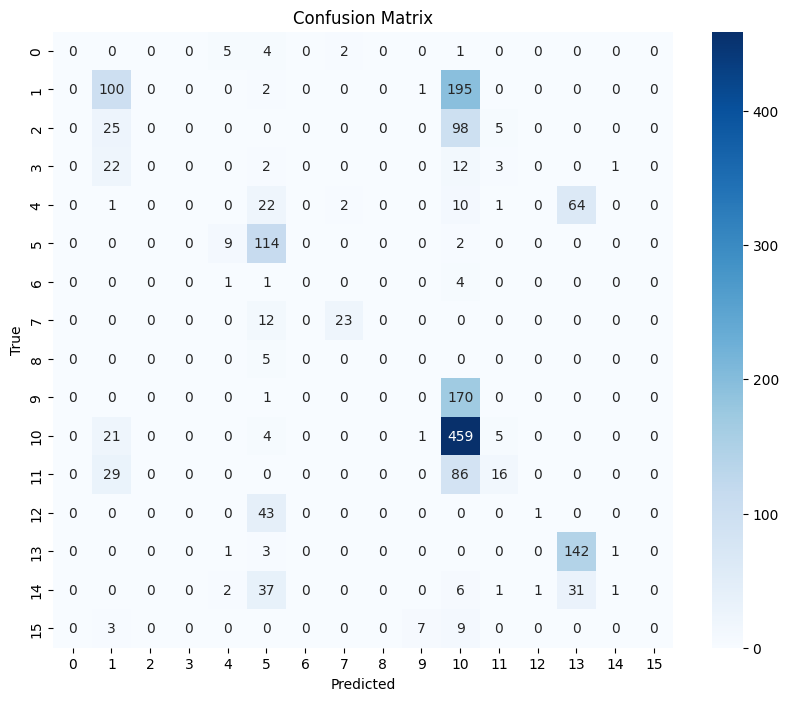

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import files
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

tf.disable_v2_behavior()

# Upload file
def upload_hsi_dataset():
    uploaded = files.upload()
    for fname in uploaded:
        if fname.endswith('.mat'):
            mat = loadmat(fname)
            key = [k for k in mat if not k.startswith('__')][0]
            return mat[key]
        elif fname.endswith('.npy'):
            return np.load(fname)
        else:
            raise ValueError("File format not supported. Use .mat or .npy.")

# Preprocess function
def preprocess_data(data, labels, input_shape=(128, 128, 100), n_classes=16):
    data = data.astype(np.float32)
    data -= data.min()
    data /= data.max()

    # Crop and align
    X = data[:input_shape[0], :input_shape[1], :input_shape[2]]
    y = labels[:input_shape[0], :input_shape[1]]

    # Flatten spatial dimensions
    X = X.reshape(-1, input_shape[2])  # (128*128, 100)
    y = y.flatten()

    # Remove background pixels
    mask = y > 0
    X = X[mask]
    y = y[mask] - 1  # shift labels to start from 0

    # One-hot encode
    y = tf.keras.utils.to_categorical(y, num_classes=n_classes)

    # Reshape for 3D CNN: (samples, 1, 1, bands, 1)
    X = X[:, np.newaxis, np.newaxis, :, np.newaxis]
    return X, y

# Model
def build_model(input_tensor, keep_prob, n_classes):
    def conv3d(x, W): return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')
    def max_pool3d(x): return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
    def weight_variable(shape): return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    def bias_variable(shape): return tf.Variable(tf.constant(0.1, shape=shape))

    W1 = weight_variable([1,1,7,1,32])
    b1 = bias_variable([32])
    h1 = tf.nn.relu(conv3d(input_tensor, W1) + b1)
    h1 = max_pool3d(h1)

    W2 = weight_variable([1,1,5,32,64])
    b2 = bias_variable([64])
    h2 = tf.nn.relu(conv3d(h1, W2) + b2)
    h2 = max_pool3d(h2)

    flat_size = np.prod(h2.get_shape().as_list()[1:])
    h_flat = tf.reshape(h2, [-1, flat_size])

    W_fc1 = weight_variable([flat_size, 256])
    b_fc1 = bias_variable([256])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([256, n_classes])
    b_fc2 = bias_variable([n_classes])
    logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return logits

# === Main Execution ===

print("Upload hyperspectral data (.npy)...")
data = upload_hsi_dataset()
print("Upload corresponding label data (.npy)...")
labels = upload_hsi_dataset()

# Prepare data
X, y = preprocess_data(data, labels, input_shape=(128,128,100), n_classes=16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF Graph
x_input = tf.placeholder(tf.float32, shape=[None, 1, 1, 100, 1])
y_true = tf.placeholder(tf.float32, shape=[None, y.shape[1]])
keep_prob = tf.placeholder(tf.float32)

logits = build_model(x_input, keep_prob, y.shape[1])
prediction = tf.argmax(logits, 1)
true_label = tf.argmax(y_true, 1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct = tf.equal(prediction, true_label)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    epochs = 10
    batch_size = 32
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_x = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            sess.run(train_step, feed_dict={x_input: batch_x, y_true: batch_y, keep_prob: 0.5})
        acc = sess.run(accuracy, feed_dict={x_input: X_test, y_true: y_test, keep_prob: 1.0})
        print(f"Epoch {epoch+1}, Test Accuracy: {acc:.4f}")

    # Evaluation
    y_pred = sess.run(prediction, feed_dict={x_input: X_test, keep_prob: 1.0})
    y_true_vals = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_vals, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true_vals, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
